## Visualize Receptive Fields after Aligning for Moving Stimuli

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage
import pandas as pd

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

from scipy.ndimage import gaussian_filter

import xarray as xr

#from fly2p.viz.viz import myAxisTheme
#import fly2p.preproc.imgPreproc as imp
from unityvr.analysis.stimAnalysis import convertTextureVals, deriveTexVals
from unityvr.preproc import logproc as lp

import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML
import matplotlib
from unityvr.analysis.align2img import *
import re

matplotlib.rcParams['animation.embed_limit'] = 2**128
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [ ]:
onCluster = True
useNapari = False #and not onCluster

## Specify data directory

In [5]:
storageDir='/groups/jayaraman' if onCluster else '/Volumes'
rootDir = storageDir+'/jayaramanlab/Shivam/Projects/predictiveCoding/Data/'
#Volumes/
subdir = 'RFMapWN'
genotype = 'SS00238_x_6f-Shi'
region = 'BU'
flyID = 'f01'
RFmappingCondition = 'pOLmapRF2-20'
regtrial = 'trial01'

In [6]:
plotDir = sep.join([rootDir, 'plot', subdir,genotype,region,flyID])
preprocDir = sep.join([rootDir, 'preproc', subdir,genotype,region,flyID])
print('Genotype: {}, Imaging region: {}, Fly id: {}\nCondition: {}, Trial: {}'.format(
    genotype, region, flyID, RFmappingCondition, regtrial))

Genotype: SS00238_x_6f-Shi, Imaging region: BU, Fly id: f01
Condition: pOLmapRF2-20, Trial: trial01


In [7]:
# Generate directory where to save plots
saveDir = sep.join([plotDir, 'RFMaps/']) #condition
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

ppsaveDir = sep.join([preprocDir])
if not exists(ppsaveDir):
    makedirs(ppsaveDir)
print(ppsaveDir)

/groups/jayaraman/jayaramanlab/Shivam/Projects/predictiveCoding/Data//plot/RFMapWN/SS00238_x_6f-Shi/BU/f01/RFMaps/
/groups/jayaraman/jayaramanlab/Shivam/Projects/predictiveCoding/Data//preproc/RFMapWN/SS00238_x_6f-Shi/BU/f01


In [8]:
refGlomMask = np.load(sep.join([rootDir,'preproc', subdir, genotype, region, flyID, 'reg2'+regtrial, 'refGlomRoiMask.npy']))
refStack = np.load(sep.join([rootDir,'preproc', subdir, genotype, region, flyID, 'reg2'+regtrial, 'refF0stack.npy']))

In [9]:
roiDat = pd.read_csv(sep.join([rootDir,'preproc', subdir, genotype, region, flyID, 'reg2'+regtrial,'glomRoiDFF_registered.csv'])).drop(columns=['Unnamed: 0'])
roiDFF = roiDat.query('experiment == "{}" & trial == "{}"'.format(RFmappingCondition, regtrial)).copy().reset_index(drop=True)
path2imgdat = sep.join([ppsaveDir,RFmappingCondition+sep+regtrial, 'img'])
with open(path2imgdat+sep+'imgMetadata.json') as f:
    import json
    imgMetadat = json.load(f)

In [10]:
path2unity = sep.join([ppsaveDir,RFmappingCondition+sep+regtrial, 'uvr'])
uvrDat = lp.loadUVRData(path2unity)
uvrDat.texDf = deriveTexVals(convertTextureVals(uvrDat.texDf))

Difference between first unity frame that starts logging photodiode values and first high photodiode frame: 8.0
Number of imaging frames detected: 59710
Truncated recording. Difference in length: 3 imaging volumes


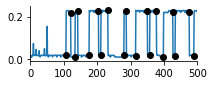

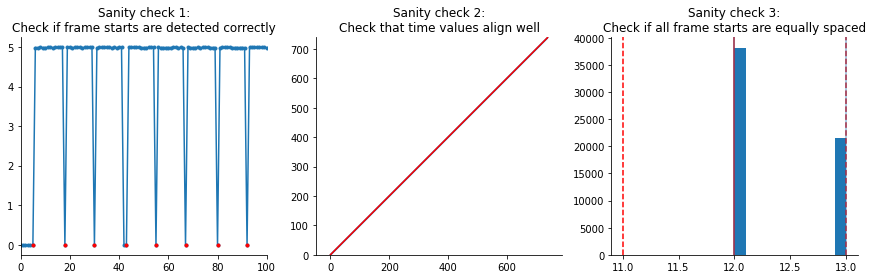

In [12]:
expDf = generateUnityExpDf(roiDFF['time [s]'].values, uvrDat, imgMetadat, timeStr='time [s]', findImgFrameTimes_params={'diffVal':3, 'pdAlign':True, 'supressPDAlignmentPlot':False, 'pdThresh':0.18, 'lims':[0,500]}, mergeUnityDfs_params= {'on' :['frame', 'time', 'time [s]']});

In [13]:
roiDFF = truncateImgDataToUnityDf(roiDFF, expDf, timeStr = 'time [s]')
combiImgUnityDf = pd.merge(roiDFF, expDf, on = ['time [s]'])

## Plot receptive fields

In [25]:
rois = [1,2,3,4,6]
if rois == 'all': 
    rois = list(roiDFF.columns[roiDFF.columns.str.contains('roi')])
else:
    rois = list('roi'+pd.Series(rois).astype('str'))

In [26]:
import matplotlib.colors as colors
myClstMap = 'Dark2'
cNorm  = colors.Normalize(vmin=1, vmax=len(list(roiDFF.columns[roiDFF.columns.str.contains('roi')])))
glomCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)
colorsPal = sns.color_palette(myClstMap, len(list(roiDFF.columns[roiDFF.columns.str.contains('roi')])))

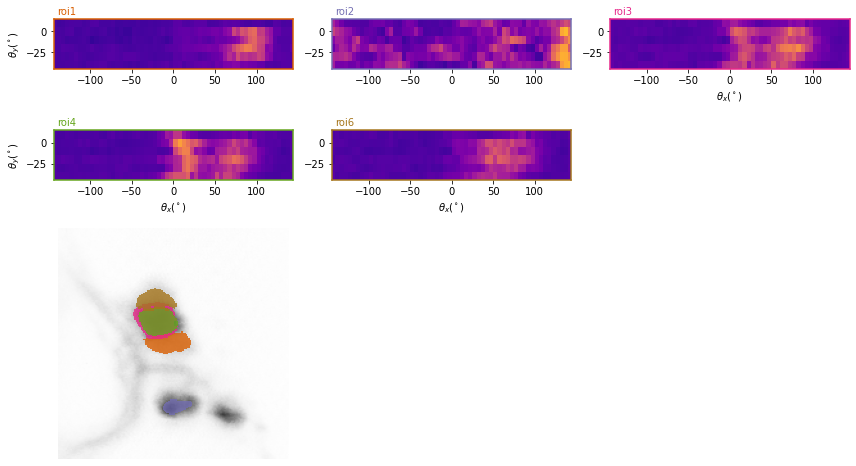

In [27]:
cols = int(np.ceil(np.sqrt(len(rois))))
rows = int(np.ceil(len(rois) / cols))
fig,ax = plt.subplots(rows+1,cols,figsize = (4*cols,2.2*(rows+1)), gridspec_kw={'height_ratios': [1]*rows + [3]})
ax = ax.flatten()

resolution_x = 2.5 #deg
resolution_y = 10 #deg
onScreen = (combiImgUnityDf['behindScreen']!=1)
combiImgUnityDf['stimAngleBinned'] = pd.cut(combiImgUnityDf.stimAngle, int(np.round(360/resolution_x)), precision = 0)
combiImgUnityDf['elevationBinned'] = pd.cut(combiImgUnityDf.elevationDegs, int(np.round((360/resolution_y)*(combiImgUnityDf.elevationDegs.max()-combiImgUnityDf.elevationDegs.min())/(combiImgUnityDf.stimAngle.max()-combiImgUnityDf.stimAngle.min()))), precision=0)
angle = combiImgUnityDf.groupby('stimAngleBinned')['stimAngle'].mean().round(-1).values
elevation = combiImgUnityDf.groupby('elevationBinned')['elevationDegs'].mean().round(-1).values

ax[-int(np.round(cols))].imshow(refStack.max(axis=0), cmap='Greys')
ax[-int(np.round(cols))].set_axis_off()

for r, roi in enumerate(rois):
    roiN = int(re.findall(r'\d+\.?\d*', roi)[0])
    mycolor = colorsPal[roiN]
    RF = combiImgUnityDf.pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values
    ax[r].pcolormesh(angle, elevation, RF, cmap='plasma', shading = 'auto', vmin=combiImgUnityDf[roi].min(), vmax=combiImgUnityDf[roi].max(), edgecolors = None);
    ax[r].set_aspect('equal');
    ax[r].set_xlim([combiImgUnityDf[onScreen].stimAngle.min(), combiImgUnityDf[onScreen].stimAngle.max()]);
    ax[r].set_ylim([-45, 15]);
    if r>=(rows*cols-cols): 
        ax[r].set_xlabel(r'$\theta_x (^\circ)$')
    else: ax[r].set_xlabel(None)
    if (r%cols==0): ax[r].set_ylabel(r'$\theta_y (^\circ)$');
    else: ax[r].set_ylabel(None)
    ax[r].text(-140,20,roi,color=mycolor);
    for spine in ax[r].spines.values():
        spine.set_edgecolor(mycolor)  # Set the border color
        spine.set_linewidth(1.5)
    myRoi = np.nanmax(refGlomMask,axis=0)
    myRoi[myRoi!=roiN] = -np.inf
    ax[-int(np.round(cols))].imshow(np.nanmax(myRoi,axis=0), cmap=myClstMap, vmin = 0, vmax=np.nanmax(refGlomMask), alpha=0.8);

for ai, axis in enumerate(ax):    
    if not axis.has_data(): 
        fig.delaxes(axis)
        ax[ai-cols].set_xlabel(r'$\theta_x (^\circ)$')

# Adjust layout to handle missing subplots
fig.tight_layout()
fig.savefig(saveDir + '_'.join(['receptive-field-maps-selected','fly-'+flyID,'condition-'+RFmappingCondition,'reg2-'+regtrial+'.pdf']));

## Plot Shifted RFs

In [28]:
rois = [1,2,3,4,6] #'all' 
if rois == 'all': 
    rois = list(roiDFF.columns[roiDFF.columns.str.contains('roi')])
else:
    rois = list('roi'+pd.Series(rois).astype('str'))

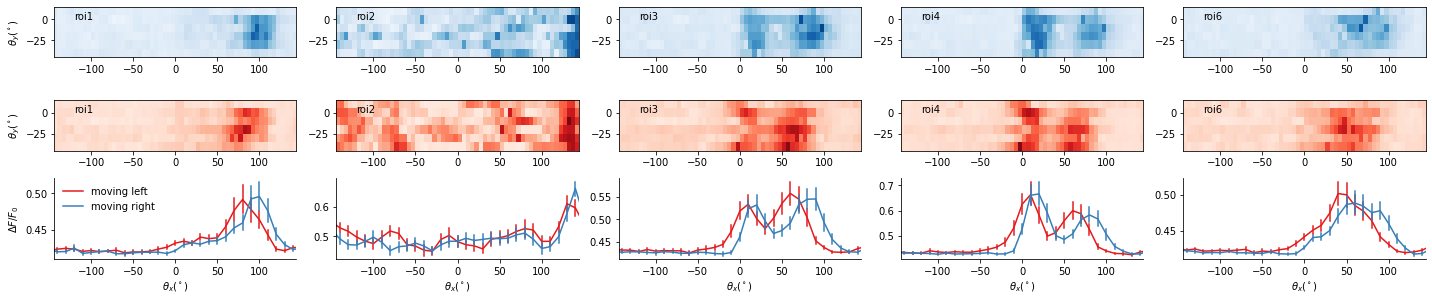

In [29]:
cols = len(rois)
rows = 3
fig,ax = plt.subplots(rows,cols,figsize = (4*cols,1.5*(rows)), gridspec_kw={'height_ratios': [1,1,1]})
ax = ax.flatten()

resolution_x = 2.5 #deg
resolution_y = 10 #deg
onScreen = (combiImgUnityDf['behindScreen']!=1)
combiImgUnityDf['stimAngleBinned'] = pd.cut(combiImgUnityDf.stimAngle, int(np.round(360/resolution_x)), precision = 0)
combiImgUnityDf['elevationBinned'] = pd.cut(combiImgUnityDf.elevationDegs, int(np.round((360/resolution_y)*(combiImgUnityDf.elevationDegs.max()-combiImgUnityDf.elevationDegs.min())/(combiImgUnityDf.stimAngle.max()-combiImgUnityDf.stimAngle.min()))), precision=0)
clockwise = combiImgUnityDf['stimVel']>0
angle = combiImgUnityDf.groupby('stimAngleBinned')['stimAngle'].mean().round(-1).values
elevation = combiImgUnityDf.groupby('elevationBinned')['elevationDegs'].mean().round(-1).values
cmaps = ['Blues','Reds']

for r, roi in enumerate(rois):
    RFclockwise = combiImgUnityDf.loc[clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values
    RFcounterclockwise = combiImgUnityDf.loc[~clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values
    RF = [RFclockwise, RFcounterclockwise]
    for vi,v in enumerate([r+int(r/cols)*cols,r+int(r/cols)*cols+cols]):
        ax[v].pcolormesh(angle, elevation, RF[vi], cmap=cmaps[vi], shading = 'auto', vmin=combiImgUnityDf[roi].min(), vmax=combiImgUnityDf[roi].max(), edgecolors = None);
        ax[v].set_aspect('equal');
        ax[v].set_aspect('equal');
        
        ax[v].set_xlim([combiImgUnityDf[onScreen].stimAngle.min(), combiImgUnityDf[onScreen].stimAngle.max()]);
        ax[v].set_ylim([-45, 15]);
        if v>=(rows*cols-cols): 
            ax[v].set_xlabel(r'$\theta_x (^\circ)$')
        else: ax[v].set_xlabel(None)
        if (v%cols==0): ax[v].set_ylabel(r'$\theta_y (^\circ)$');
        else: ax[v].set_ylabel(None)
        ax[v].text(-120,0,roi,color='k');

    sns.lineplot(x=combiImgUnityDf['stimAngle'].round(-1), y=combiImgUnityDf[roi], err_style='bars', hue=clockwise, ax=ax[r+int(r/cols)*cols+2*cols], palette='Set1')
    sns.despine(ax=ax[r+int(r/cols)*cols+2*cols])
    ax[r+int(r/cols)*cols+2*cols].set_xlabel(r'$\theta_x (^\circ)$')
    if ((r+int(r/cols)*cols+2*cols)%cols==0): 
        ax[r+int(r/cols)*cols+2*cols].set_ylabel(r'$\Delta F/F_0$')
    else:
        ax[r+int(r/cols)*cols+2*cols].set_ylabel(None)
    ax[r+int(r/cols)*cols+2*cols].legend().set_visible(False)
    ax[r+int(r/cols)*cols+2*cols].set_xlim([combiImgUnityDf[onScreen].stimAngle.min(), combiImgUnityDf[onScreen].stimAngle.max()]);
    #ax[r+int(r/cols)*cols+2*cols].set_ylim([0.4,0.75])

ax[-cols].legend(['moving left', 'moving right'],frameon=False)

# Adjust layout to handle missing subplots
fig.tight_layout()
fig.savefig(saveDir + '_'.join(['receptive-field-maps-selected-Shifted','fly-'+flyID,'condition-'+RFmappingCondition,'reg2-'+regtrial+'.pdf']));

## Plot Right-Left Cross-Correlation

In [16]:
rois = [1,2,3,4,6] #'all'
if rois == 'all': 
    rois = list(roiDFF.columns[roiDFF.columns.str.contains('roi')])
else:
    rois = list('roi'+pd.Series(rois).astype('str'))

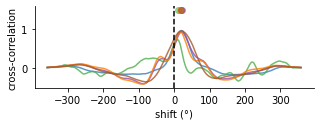

In [17]:
from predUtils import *
fig, ax = plt.subplots(1,1,figsize=(5, 1.5))
sns.set_palette(myClstMap)
for roi in rois:
    roiN = int(re.findall(r'\d+\.?\d*', roi)[0])
    mycolor = colorsPal[roiN]

    RFclockwise1d = combiImgUnityDf.loc[clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)
    RFcounterclockwise1d = combiImgUnityDf.loc[~clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)

    # Compute normalized cross-correlation
    cross_corr = normalized_cross_correlation(RFclockwise1d, RFcounterclockwise1d)

    # Calculate the lag array
    lags = np.arange(-len(RFclockwise1d) + 1, len(RFcounterclockwise1d))*resolution_x

    # Plot cross-correlation vs lag
    plt.plot(lags, cross_corr, color=mycolor, alpha=0.8)
    plt.plot(lags[np.argmax(cross_corr)],1.5,'o',alpha=0.5,color=mycolor)

plt.axvline(0,color='k',linestyle='--')
plt.xlabel('shift (°)')
plt.ylabel('cross-correlation')
sns.despine()
fig.savefig(saveDir + '_'.join(['normalized-cross-correlation-shifts','fly-'+flyID,'condition-'+RFmappingCondition,'reg2-'+regtrial+'.pdf']),bbox_inches='tight');


## Compare to Shibire Silencing

In [18]:
condition = 'pOLmapRF2-20'
trial = 'trial02'

In [34]:
roiDFFShi = roiDat.query('experiment == "{}" & trial == "{}"'.format(condition, trial)).copy().reset_index(drop=True)
path2unity = sep.join([ppsaveDir,condition+sep+trial, 'uvr'])
uvrDat = lp.loadUVRData(path2unity)
uvrDat.texDf = deriveTexVals(convertTextureVals(uvrDat.texDf))

path2imgdat = sep.join([ppsaveDir,condition+sep+trial, 'img'])
with open(path2imgdat+sep+'imgMetadata.json') as f:
    import json
    imgMetadat = json.load(f)
expDfShi = generateUnityExpDf(roiDFFShi['time [s]'].values, uvrDat, imgMetadat, timeStr='time [s]', mergeUnityDfs_params= {'on' :['frame', 'time', 'time [s]']}, suppressDepugPlot=True);
roiDFFShi = truncateImgDataToUnityDf(roiDFFShi, expDfShi, timeStr = 'time [s]')
combiImgUnityDfShi = pd.merge(roiDFFShi, expDfShi, on = ['time [s]'])
combiImgUnityDfShi['stimAngleBinned'] = pd.cut(combiImgUnityDfShi.stimAngle, int(np.round(360/resolution_x)), precision = 0)
combiImgUnityDfShi['elevationBinned'] = pd.cut(combiImgUnityDfShi.elevationDegs, int(np.round((360/resolution_y)*(combiImgUnityDfShi.elevationDegs.max()-combiImgUnityDfShi.elevationDegs.min())/(combiImgUnityDfShi.stimAngle.max()-combiImgUnityDfShi.stimAngle.min()))), precision=0)


Truncated recording. Difference in length: 4 unity frames


In [52]:
shiftDfShi = pd.DataFrame(rois,columns = ['rois'])
shiftDfShi['control'] = np.zeros(len(rois))
shiftDfShi['shibire'] = np.zeros(len(rois))
columns = ['control','shibire']
for ei, experiment in enumerate([combiImgUnityDf,combiImgUnityDfShi]):
    for roi in rois:
        roiN = int(re.findall(r'\d+\.?\d*', roi)[0])
        RFclockwise1d = experiment.loc[clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)
        RFcounterclockwise1d = experiment.loc[~clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)
        # Compute normalized cross-correlation
        cross_corr = normalized_cross_correlation(RFclockwise1d, RFcounterclockwise1d)
        # Calculate the lag array
        lags = np.arange(-len(RFclockwise1d) + 1, len(RFcounterclockwise1d))*resolution_x
        shiftDfShi.loc[shiftDfShi['rois']==roi,columns[ei]] = lags[np.argmax(cross_corr)]
shiftDfShi = pd.melt(shiftDfShi, id_vars=['rois'], value_vars = ['control','shibire'], value_name='shift', var_name='experiment')

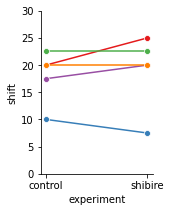

In [64]:
plt.figure(figsize = (2,3))
sns.lineplot(x='experiment',y='shift',data=shiftDfShi,hue='rois',marker='o')
plt.ylim(0,30);
plt.legend().set_visible(False)
sns.despine()

In [ ]:
from predUtils import *
fig, ax = plt.subplots(1,1,figsize=(5, 1.5))
sns.set_palette(myClstMap)
for roi in rois:
    roiN = int(re.findall(r'\d+\.?\d*', roi)[0])
    mycolor = colorsPal[roiN]

    RFclockwise1d = combiImgUnityDf.loc[clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)
    RFcounterclockwise1d = combiImgUnityDf.loc[~clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)

    # Compute normalized cross-correlation
    cross_corr = normalized_cross_correlation(RFclockwise1d, RFcounterclockwise1d)

    # Calculate the lag array
    lags = np.arange(-len(RFclockwise1d) + 1, len(RFcounterclockwise1d))*resolution_x

    # Plot cross-correlation vs lag
    plt.plot(lags, cross_corr, color=mycolor, alpha=0.8)
    plt.plot(lags[np.argmax(cross_corr)],1.5,'o',alpha=0.5,color=mycolor)

In [108]:
def normalized_cross_correlation(sig1, sig2):
    # Compute the cross-correlation using correlate
    corr = correlate(sig1 - np.mean(sig1), sig2 - np.mean(sig2), mode='full')
    # Normalize the result
    normalization_factor = np.sqrt(np.sum((sig1 - np.mean(sig1)) ** 2) * np.sum((sig2 - np.mean(sig2)) ** 2))
    return corr / normalization_factor

In [109]:
import numpy as np
from scipy.signal import correlate

# Example 1D functions (signals)
signal1 = clockwiseRF
signal2 = counterclockwiseRF

# Compute cross-correlation
cross_corr = normalized_cross_correlation(signal1, signal2)

# Find the index of the maximum value in the cross-correlation
max_index = np.argmax(cross_corr)

# Calculate the shift
# The center of the correlation result corresponds to zero shift
zero_shift_index = len(signal1) - 1
shift = max_index - zero_shift_index

print(f"The computed shift between the two signals is: {shift}")


The computed shift between the two signals is: 8


In [110]:
resolution_x*8

20.0

In [118]:
clockwiseRF = combiImgUnityDf.loc[clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)
counterclockwiseRF = combiImgUnityDf.loc[~clockwise].pivot_table(index='stimAngleBinned', columns='elevationBinned', values=roi, aggfunc=np.nanmean).T.values.mean(axis=0)
#lags = sp.signal.correlation_lags(len(clockwiseRF), len(counterclockwiseRF))
#corr = sp.signal.correlate(clockwiseRF, counterclockwiseRF)
#plt.plot(lags,corr)
#plt.axvline(0)

In [5]:
# Generate directory where to save plots
saveDir = sep.join([plotDir, 'DFF']) #condition
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

ppsaveDir = sep.join([preprocDir])
if not exists(ppsaveDir):
    makedirs(ppsaveDir)
print(ppsaveDir)

/groups/jayaraman/jayaramanlab/Hannah/Projects/FlyVR2P/Data//plot/OLmapRFPred/SS00238_x_SP-I-7f/EB-BU/f01/DFF
/groups/jayaraman/jayaramanlab/Hannah/Projects/FlyVR2P/Data//preproc/OLmapRFPred/SS00238_x_SP-I-7f/EB-BU/f01


## Import data

In [6]:
path2imgdat = sep.join([ppsaveDir,condition+sep+trial, 'img'])
stackMC = xr.open_dataarray(path2imgdat+sep+'stackMC.nc', 
                            engine="scipy")
dffStack = xr.open_dataarray(path2imgdat+sep+'dffStack.nc', 
                            engine="scipy")
with open(path2imgdat+sep+'imgMetadata.json') as f:
    import json
    imgMetadat = json.load(f)

In [7]:
path2unity = sep.join([ppsaveDir,condition+sep+trial, 'uvr'])
uvrDat = lp.loadUVRData(path2unity)
uvrDat.texDf = deriveTexVals(convertTextureVals(uvrDat.texDf))

Truncated recording. Difference in length: 22 unity frames


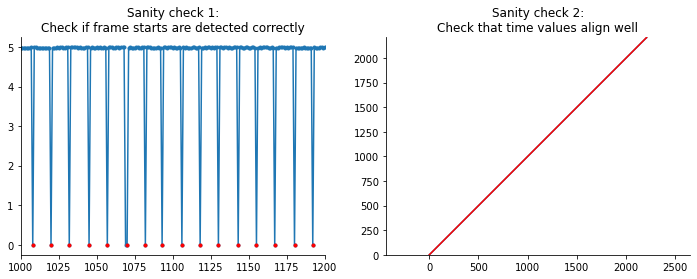

In [8]:
expDf = generateUnityExpDf(dffStack['volumes [s]'].values, uvrDat, imgMetadat);

## Sweep Videos

In [9]:
dffStack = truncateImgDataToUnityDf(dffStack, expDf)
stackMC = truncateImgDataToUnityDf(stackMC, expDf)

In [58]:
Nbins = 200
sweepOrder = [1,-1] #left handed convention: +1 is clockwise sweep from the fly's PoV (ie left to right) and -1 is counterclockwise (right to left)
forward = -1 #-1 = counterclockwise sweep forward in time, 1 = clockwise sweep forward in time
timeColors = ['crimson', 'steelblue'] #[forward, backward]
stimSpeed = 10

In [59]:
bins = np.linspace(expDf['stimAngle'].min(), expDf['stimAngle'].max(), Nbins) if forward == 1 else np.linspace(expDf['stimAngle'].max(), expDf['stimAngle'].min(), Nbins)
digitized = np.digitize(expDf['stimAngle'].values, bins)
binnedX = bins[digitized-1]
meanStack = np.zeros([2, Nbins, stackMC.shape[1], stackMC.shape[2], stackMC.shape[3]])
meanDff = np.zeros([2, Nbins, dffStack.shape[1], dffStack.shape[2], dffStack.shape[3]])

In [60]:
for d,dir in enumerate(sweepOrder):
    for i in range(Nbins):
        condition = (binnedX==bins[i]) & (dir*expDf['stimVel']>0) & (expDf['stimSpeed']==stimSpeed)
        if np.sum(condition)>0:
            meanStack[d,i,:,:,:] = stackMC[condition,:,:,:].mean(axis=0).values
            meanDff[d,i,:,:,:] = dffStack[condition,:,:,:].mean(axis=0).values
            if i%int(Nbins/10)==0:
                print('.',end="")
        else:
            meanStack[d,:,:,:]==0
            meanDff[d,:,:,:]==0
            print('x',end="")
    print("\n")

..........x

..........x



In [61]:
if useNapari: 
    import napari
    viewer = napari.view_image(meanDff.max(axis=2))

In [63]:
RFstimDeg = 5
intensityClip = [90,99.95]
raw_or_dff = "dff"

In [64]:
%%capture

maxStack = meanStack.max(axis=2) if raw_or_dff == "raw" else gaussian_filter(meanDff.max(axis=2), sigma=[0,0,2,2])

#initialize
fig,ax = plt.subplots(2,2,figsize = (8,6),gridspec_kw={'height_ratios': [6, 1.5]})

img = ax[0,0].imshow(maxStack[0,0,:,:],vmin=np.percentile(maxStack,intensityClip[0]),vmax=np.percentile(maxStack,intensityClip[1]));
img2 = ax[0,1].imshow(maxStack[1,0,:,:],vmin=np.percentile(maxStack,intensityClip[0]),vmax=np.percentile(maxStack,intensityClip[1]));


line1f = ax[1,0].axvline(bins[0]+RFstimDeg/2*sweepOrder[0],color='k', alpha=1,zorder=-1);
line1b = ax[1,0].axvline(bins[0]-RFstimDeg/2*sweepOrder[0],color='k', alpha=0.5,zorder=-1);
arrow1 = ax[1,0].arrow(bins[0]-RFstimDeg/2*sweepOrder[0], 0.5, 4*RFstimDeg*sweepOrder[0], 0, head_length=5, width=0.02, length_includes_head=True, color=[timeColors[i] for i,j in enumerate(
    sweepOrder) if j==forward][0],zorder=1);
line2f = ax[1,1].axvline(bins[0]+RFstimDeg/2*sweepOrder[1],color='k', alpha=1,zorder=-1);
line2b = ax[1,1].axvline(bins[0]-RFstimDeg/2*sweepOrder[1],color='k', alpha=0.5,zorder=-1);
arrow2 = ax[1,1].arrow(bins[0]-RFstimDeg/2*sweepOrder[1], 0.5, 4*RFstimDeg*sweepOrder[1], 0, head_length=5, width=0.02, length_includes_head=True, color=[timeColors[i] for i,j in enumerate(
    sweepOrder) if j!=forward][0],zorder=1);
legend = ax[1,1].legend(['ON-edge', 'OFF-edge'], frameon=False, bbox_to_anchor=[-0.1,1.5], loc='upper left',mode = "expand", ncol = 2)

for i,_ in enumerate(sweepOrder):
    ax[1,i].set_xlim(-180,180)
    ax[1,i].set_ylim(0,1)
    ax[1,i].set_xlabel("stimulus position (°)")
    ax[1,i].set_yticks([])
    sns.despine(ax=ax[1,i], left=True)

def animate(i):
    img.set_data(maxStack[0,i,:,:])
    img2.set_data(maxStack[1,i,:,:])
    line1f.set_data([bins[i]+RFstimDeg/2*sweepOrder[0], bins[i]+RFstimDeg/2*sweepOrder[0]], [0, 1])
    line1b.set_data([bins[i]-RFstimDeg/2*sweepOrder[0], bins[i]-RFstimDeg/2*sweepOrder[0]], [0, 1])
    arrow1.set_data(x=bins[i]-RFstimDeg/2*sweepOrder[0], y=0.5, dx=4*RFstimDeg*sweepOrder[0], dy=0)
    line2f.set_data([bins[i]+RFstimDeg/2*sweepOrder[1], bins[i]+RFstimDeg/2*sweepOrder[1]], [0, 1])
    line2b.set_data([bins[i]-RFstimDeg/2*sweepOrder[1], bins[i]-RFstimDeg/2*sweepOrder[1]], [0, 1])
    arrow2.set_data(x=bins[i]-RFstimDeg/2*sweepOrder[1], y=0.5, dx=4*RFstimDeg*sweepOrder[1], dy=0)

In [65]:
ani = FuncAnimation(fig, animate, interval=40, frames=Nbins)
HTML(ani.to_jshtml())

In [80]:
dirLabel = "left" if forward==1 else "right"
ani.save(sep.join([saveDir, dirLabel+"_forward_sweep_"+raw_or_dff+"_averaged_over_elevation.mp4"]), dpi=350, writer=FFMpegWriter(fps=10));
ani.save(sep.join([saveDir, dirLabel+"_forward_sweep_"+raw_or_dff+"_averaged_over_elevation.gif"]), dpi=350, writer=PillowWriter(fps=10));

In [81]:
1+1

2